## 例：クーポンの配布

ECサイトにおいてクーポンをユーザーに配布する施策を行った状況を想定し、クーポンという処置が購入する確率に与えた影響を調べたいとする。その際に、

1. ランダムにクーポン配布が行われたケース
2. 前月に購入したユーザーにクーポンが配布されたケース

という2つの処置割当メカニズムがあったと仮定して比較を行う。クーポンは同じもので効果も同じとする。

また、ユーザーは通常の顧客と、成約率が高いロイヤルカスタマーの2種類いるとする。

乱数を生成してシミュレーションしてみる

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

ate = 0.1  # 真の効果
n = 5000
users = pd.DataFrame()

# 通常の顧客とロイヤルカスタマーの2つのグループがあり、毎月の成約率が異なるとする
p_normal = 0.2
p_loyal = 0.5

# ロイヤルカスタマーは全体の2割いるとする
is_loyal = np.random.binomial(n=1, p=0.2, size=n)

# 先月の購入の有無
p1 = is_loyal * np.random.binomial(n=1, p=p_loyal, size=n)
p2 = (1 - is_loyal) * np.random.binomial(n=1, p=p_normal, size=n)
users.loc[:, "prev_purchase"] = p1 + p2

# 1. ランダム配布の場合
d = np.random.binomial(n=1, p=0.5, size=n)
p1 = d * np.random.binomial(n=1, p=p_normal + ate, size=n) + (1 - d) * np.random.binomial(n=1, p=p_normal, size=n)
p2 = d * np.random.binomial(n=1, p=p_loyal + ate, size=n) + (1 - d) * np.random.binomial(n=1, p=p_loyal, size=n)
users.loc[:, "purchase_1"] = is_loyal * p1 + (1 - is_loyal) * p2
users.loc[:, "assignment_1"] = d

# 2. ユーザーを選ぶ場合
d = users["prev_purchase"]
p1 = d * np.random.binomial(n=1, p=p_normal + ate, size=n) + (1 - d) * np.random.binomial(n=1, p=p_normal, size=n)
p2 = d * np.random.binomial(n=1, p=p_loyal + ate, size=n) + (1 - d) * np.random.binomial(n=1, p=p_loyal, size=n)
users.loc[:, "purchase_2"] = is_loyal * p1 + (1 - is_loyal) * p2
users.loc[:, "assignment_2"] = d

# 各群の平均の差分をとって（ナイーブな推定量を使って）ATEを推定してみる
agg1 = users.groupby("assignment_1")["purchase_1"].agg(["mean", "count"])
agg2 = users.groupby("assignment_2")["purchase_2"].agg(["mean", "count"])
result = f"""
--- ナイーブな推定量 ---
1. ランダム配布の場合
対照群： 成約率={agg1['mean'][0]:.3g} n={agg1['count'][0]:,}
処置群： 成約率={agg1['mean'][1]:.3g} n={agg1['count'][1]:,}
成約率の差： {agg1['mean'][1] - agg1['mean'][0]:.3g}

2. ユーザーを選ぶ場合
対照群： 成約率={agg2['mean'][0]:.3g} n={agg2['count'][0]:,}
処置群： 成約率={agg2['mean'][1]:.3g} n={agg2['count'][1]:,}
成約率の差： {agg2['mean'][1] - agg2['mean'][0]:.3g}
"""
print(result)


--- ナイーブな推定量 ---
1. ランダム配布の場合
対照群： 成約率=0.439 n=2,497
処置群： 成約率=0.549 n=2,503
成約率の差： 0.11

2. ユーザーを選ぶ場合
対照群： 成約率=0.465 n=3,723
処置群： 成約率=0.485 n=1,277
成約率の差： 0.0201



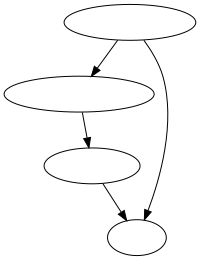

In [2]:
import graphviz
g = graphviz.Digraph()
g.edge('ロイヤルティ', '先月の購入履歴')
g.edge('先月の購入履歴', 'クーポン')
g.edge('クーポン', '購入')
g.edge('ロイヤルティ', '購入')
g

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer


# 多重共線性
models = [
    smf.ols('purchase_2 ~ assignment_2', data=users).fit(),
    smf.ols('purchase_2 ~ assignment_2 + prev_purchase', data=users).fit(),
]
Stargazer(models)